<a href="https://colab.research.google.com/github/Mateusz-best-creator/PyTorch_DogBreeds/blob/main/PyTorchDogBreeds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !unzip drive/MyDrive/dog_breeds_data/dog-breed-identification.zip -d drive/MyDrive/dog_breeds_data

In [77]:
!git clone https://github.com/mrdbourke/pytorch-deep-learning
!mv pytorch-deep-learning/going_modular .
!rm -rf pytorch-deep-learning

Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (227/227), done.
remote: Total 4036 (delta 1064), reused 1100 (delta 994), pack-reused 2812
Receiving objects: 100% (4036/4036), 651.60 MiB | 37.43 MiB/s, done.
Resolving deltas: 100% (2357/2357), done.
You can inspect what was checked out with 'git status'
and retry with 'git restore --source=HEAD :/'

^C
mv: cannot move 'pytorch-deep-learning/going_modular' to './going_modular': Directory not empty


In [78]:
import torch
from torch import nn

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"PyTorch version: {torch.__version__}")
print(f"Device we are going to use throughout this notebook: {device}")

PyTorch version: 2.1.0+cu118
Device we are going to use throughout this notebook: cuda


## Preparing the data

In [79]:
import matplotlib.pyplot as plt

In [80]:
import pandas as pd

# Let's get all training and testing paths
train_dataframe = pd.read_csv("/content/drive/MyDrive/dog_breeds_data/labels.csv")
train_dataframe.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [81]:
from pathlib import Path

train_paths = ["drive/MyDrive/dog_breeds_data/train/" + image_id + ".jpg" for image_id in train_dataframe["id"]]
train_labels = list(train_dataframe["breed"])
train_paths[:5], train_labels[:5]

(['drive/MyDrive/dog_breeds_data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
  'drive/MyDrive/dog_breeds_data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
  'drive/MyDrive/dog_breeds_data/train/001cdf01b096e06d78e9e5112d419397.jpg',
  'drive/MyDrive/dog_breeds_data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
  'drive/MyDrive/dog_breeds_data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg'],
 ['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever'])

### Preparing the labels

In [82]:
import numpy as np

CLASS_NAMES = np.unique(train_dataframe["breed"])
NUM_CLASSES = len(CLASS_NAMES)
train_labels = np.array(train_labels)

one_hot_encoded_labels = []

for label in train_labels:
  temporary = np.array(CLASS_NAMES == label)
  one_hot_encoded_labels.append(temporary)

one_hot_encoded_labels = np.array(one_hot_encoded_labels).astype(int)
one_hot_encoded_labels = torch.tensor(one_hot_encoded_labels.astype(float))
labels = torch.argmax(one_hot_encoded_labels, dim=-1)
labels.shape, labels[:2]

(torch.Size([10222]), tensor([19, 37]))

### Splitting data into training and validation sets

In [83]:
from sklearn.model_selection import train_test_split

# For now we wiil use only first 1000 images
NUM_IMAGES = 1500 # After experimenting we can use our entire dataset

# Let's also create validation set
X_train, X_valid, y_train, y_valid = train_test_split(train_paths[:NUM_IMAGES],
                                                      labels[:NUM_IMAGES],
                                                      test_size=0.2,
                                                      random_state=42)
# Check the shapes
len(X_train), len(y_train), len(X_valid), len(y_valid)

(1200, 1200, 300, 300)

### Visualizing some images

In [84]:
# Let's create a function to visualize some of our images
def visualize_images(images, labels, n_cols=4, n_rows=4):
  assert len(images) == n_cols*n_rows and len(labels) == n_cols*n_rows, f"Pass {n_cols*n_rows} images and labels to this function."
  fig = plt.figure(figsize=(15, 10))
  for id, (image) in enumerate(images):
    fig.add_subplot(n_rows, n_cols, id+1)
    plt.imshow(plt.imread(image))
    plt.axis(False)
    plt.title(CLASS_NAMES[labels[id]])
  plt.show()

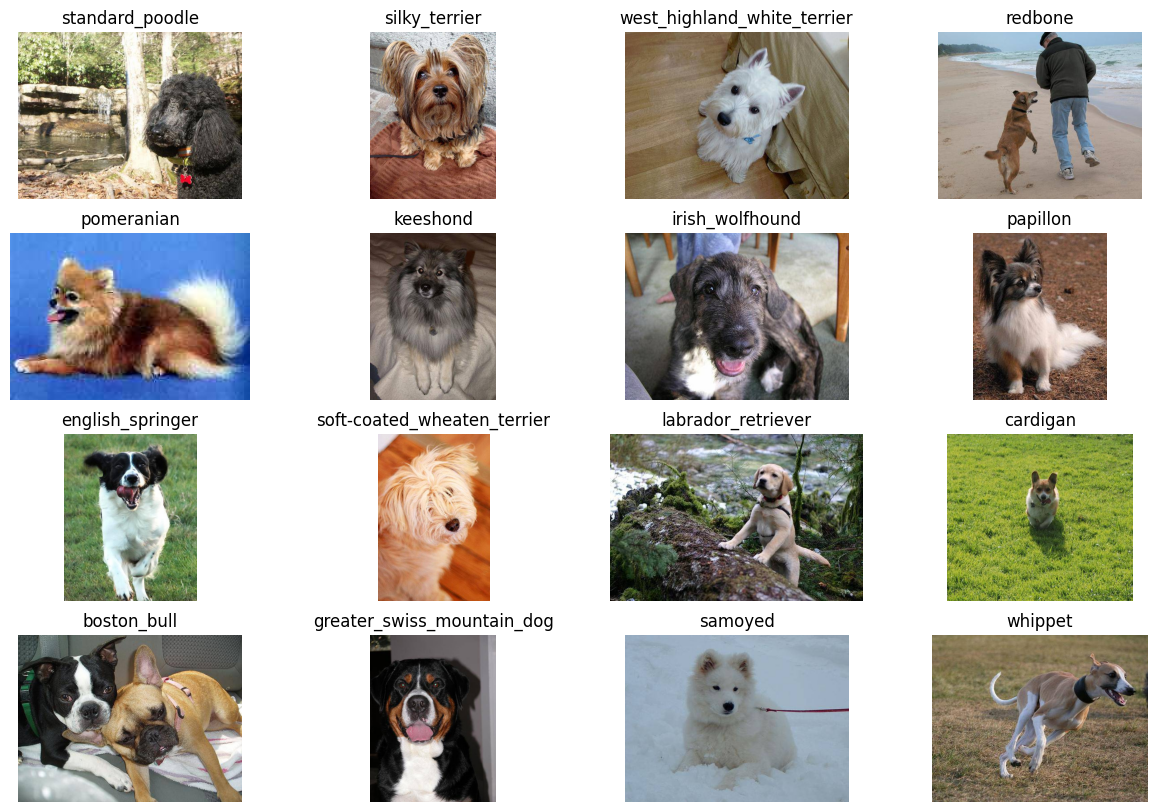

In [85]:
visualize_images(X_valid[:16], y_valid[:16])

### Creating data transformations for EfficientNetB1

In [86]:
import torchvision

print(torchvision.__version__)

0.16.0+cu118


In [87]:
# Let's get the weights of the EfficientNetB0 architecture that we are going to use
efficient_net_b1_weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT

efficientnet_data_transform = efficient_net_b1_weights.transforms()
efficientnet_data_transform

ImageClassification(
    crop_size=[240]
    resize_size=[255]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

### Preparing data transformations for EfficientNetV2S

In [115]:
efficient_net_V2S_weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT

efficientnetV2S_data_transform = efficient_net_V2S_weights.transforms()
efficientnetV2S_data_transform

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

### Creating data transformations for ResNet50

In [89]:
# Let's get the weights of the EfficientNetB0 architecture that we are going to use
resnet_50_weights = torchvision.models.ResNet50_Weights.DEFAULT

resnet_50_data_transform = resnet_50_weights.transforms()
resnet_50_data_transform

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

### Creating data transformations for MobilenetV2

In [90]:
mobilenetV2_weights = torchvision.models.MobileNet_V2_Weights.DEFAULT
mobilenet_data_transform = mobilenetV2_weights.transforms()
mobilenet_data_transform

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

### Setting paths & creating custom dataset

In [91]:
# Setup train and test paths
train_path = Path("drive/MyDrive/dog_breeds_data/train")
test_path = Path("drive/MyDrive/dog_breeds_data/test")

In [92]:
from PIL import Image

# Let's write our costom dataset
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, image_paths, labels, transform):
    self.image_paths = image_paths
    self.labels = labels
    self.transform = transform
    # self.classes, self.class_to_idx = get_classes(labels)

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, index):
    image = Image.open(self.image_paths[index])
    label = self.labels[index]
    if self.transform:
      image = self.transform(image)
    return image, label

### Creating automatic dataloaders

In [93]:
from torch.utils.data import DataLoader
import os

def create_datasets(X_train, y_train,
                    X_valid, y_valid,
                    train_transforms,
                    test_transforms):
  # Create datasets
  train_dataset = CustomDataset(image_paths=X_train,
                                labels=y_train,
                                transform=train_transforms)
  valid_dataset = CustomDataset(image_paths=X_valid,
                                labels=y_valid,
                                transform=test_transforms)
  # Create dataloaders
  BATCH_SIZE = 32
  NUM_WORKERS = os.cpu_count()

  # Create dataloaders
  train_dataloader = DataLoader(train_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True,
                                num_workers=NUM_WORKERS)
  valid_dataloader = DataLoader(valid_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                num_workers=NUM_WORKERS)
  # Return dataloaders
  return train_dataloader, valid_dataloader

#### ResNet 50

In [94]:
resnet_50_train_dataloader, resnet_50_valid_dataloader = create_datasets(X_train, y_train,
                                                                   X_valid, y_valid,
                                                                   resnet_50_data_transform,
                                                                   resnet_50_data_transform)
resnet_50_train_dataloader, resnet_50_valid_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a691fd7ddb0>,
 <torch.utils.data.dataloader.DataLoader at 0x7a691fd7dbd0>)

#### EfficientNetB1

In [95]:
# Create dataloaders
efficientnet_train_dataloader, efficientnet_valid_dataloader = create_datasets(X_train, y_train,
                                                                               X_valid, y_valid,
                                                                               efficientnet_data_transform,
                                                                               efficientnet_data_transform)

# Check how our dataloaders looks like
efficientnet_train_dataloader, efficientnet_valid_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a691fdded70>,
 <torch.utils.data.dataloader.DataLoader at 0x7a691fdddfc0>)

#### EfficientNetV2S

In [120]:
# Create custom training and validation datasets
efficientnetV2S_train_dataloader, efficientnetV2S_valid_dataloader = create_datasets(X_train, y_train,
                                                                                      X_valid, y_valid,
                                                                                      efficientnetV2S_data_transform,
                                                                                      efficientnetV2S_data_transform)
efficientnetV2S_train_dataloader, efficientnetV2S_valid_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a67f4fd8bb0>,
 <torch.utils.data.dataloader.DataLoader at 0x7a67f4fdae00>)

#### MobilenetV2

In [97]:
# Create dataloaders
mobilenet_train_dataloader, mobilenet_valid_dataloader = create_datasets(X_train, y_train,
                                                                         X_valid, y_valid,
                                                                         mobilenet_data_transform,
                                                                         mobilenet_data_transform)
# Check how our dataloaders looks like
mobilenet_train_dataloader, mobilenet_valid_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a691fdde410>,
 <torch.utils.data.dataloader.DataLoader at 0x7a691fdde560>)

## Buidling training and testing loops

### Building training loop

In [69]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
      # if batch % 30 == 0:
      #   print(f"Processing batch number: {batch}")
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

### Building test loop

In [70]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### Implement EarlyStopping Callback

In [105]:
class EarlyStopping:
    def __init__(self, patience, store_best_weights=True):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.store_best_weights = store_best_weights
        self.best_weights = None

    def __call__(self, current_score, model):
      print(f"Early stopping callback status: {self.counter}/{self.patience} | Best score: {self.best_score} | Current score: {current_score}")
      if self.best_score is None:
          self.best_score = current_score
          if self.store_best_weights:
              self.best_weights = model.state_dict()
      elif current_score < self.best_score:
          self.counter += 1
          if self.counter >= self.patience:
              return True  # Stop training
      else:
          self.best_score = current_score
          self.counter = 0
          if self.store_best_weights:
              self.best_weights = model.state_dict()

      return False  # Continue training

### Implementing `writer` for tensorboard

In [67]:
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path

def create_writer(experiment_name: str,
                  model_name: str,
                  extra_information: str=None):
  log_dir = Path("runs") / experiment_name / model_name
  if extra_information:
    log_dir = Path(log_dir) / extra_information
  writer = SummaryWriter(log_dir=log_dir)
  return writer
# Check if works
# writer = create_writer("a", "b", "c")
# writer

### Building final `train` function

In [68]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          experiment_name: str,
          model_name: str,
          extra_information: str) -> Dict[str, List]:
  # Create empty results dictionary
  results = {"train_loss": [],
              "train_acc": [],
              "test_loss": [],
              "test_acc": []}

  # Make sure model on target device
  model.to(device)

  # Create writer
  writer = create_writer(experiment_name,
                         model_name,
                         extra_information)

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                      dataloader=train_dataloader,
                                      loss_fn=loss_fn,
                                      optimizer=optimizer,
                                      device=device)
    test_loss, test_acc = test_step(model=model,
      dataloader=test_dataloader,
      loss_fn=loss_fn,
      device=device)

    # Print out what's happening
    print(
      f"Epoch: {epoch+1} | "
      f"train_loss: {train_loss:.4f} | "
      f"train_acc: {train_acc:.4f} | "
      f"test_loss: {test_loss:.4f} | "
      f"test_acc: {test_acc:.4f}"
    )

    # Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

    # Add metrics to the writer
    writer.add_scalars(main_tag="Loss",
                       tag_scalar_dict={"Train_loss": train_loss, "Test_loss": test_loss},
                       global_step=epoch)
    writer.add_scalars(main_tag="Accuracy",
                       tag_scalar_dict={"Train_accuracy": train_acc, "Test_accuracy": test_acc},
                       global_step=epoch)

    # Check if training should be stopped
    should_stop = early_stopping(test_acc, model)
    if should_stop:
        break

    # Adding the metrics for tensorboard


  # After training, if best weights were stored, you can load them like this:
  if early_stopping.best_weights:
    print(f"After training we load the best weights.")
    model.load_state_dict(early_stopping.best_weights)

  # Return the filled results at the end of the epochs
  return results

## Transfer Learning - EfficientNetB1

In [26]:
try:
  import torchinfo
except:
  !pip install torchinfo -q
  from torchinfo import summary
  import torchinfo
print(f"Torchinfo version: {torchinfo.__version__}")

Torchinfo version: 1.8.0


In [122]:
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights

model_1 = efficientnet_b1(weights=EfficientNet_B1_Weights.DEFAULT)
summary(model_1,
        input_size=(32, 3, 224, 224),
        col_names=["input_size",
                   "output_size",
                   "num_params",
                   "trainable",])

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 128MB/s]


Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 1000]                --                        True
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        True
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        --                        True
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        864                       True
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]        64                        True
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]        --                        --
│    └─Sequential: 2-2  

In [123]:
# Let's freeze all layers except last one
for layer in model_1.parameters():
  layer.requires_grad = False

model_1.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True),
                                   nn.Linear(in_features=1280, out_features=NUM_CLASSES, bias=True))
# View the summary of our model
summary(model_1,
        input_size=(32, 3, 224, 224),
        col_names=["input_size",
                   "output_size",
                   "num_params",
                   "trainable",])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 120]                 --                        Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]        --                        --
│    └─Sequential

In [125]:
model_1_optimizer = torch.optim.Adam(params=model_1.parameters())
loss_fn =nn.CrossEntropyLoss()
N_EPOCHS = 10

# Initialize the EarlyStopping callback (to reset all parameters like patience and best_score)
early_stopping = EarlyStopping(patience=5, store_best_weights=True)

model_1_results = train(model_1,
                        efficientnet_train_dataloader,
                        efficientnet_valid_dataloader,
                        model_1_optimizer,
                        loss_fn,
                        N_EPOCHS,
                        device,
                        "1500_images",
                        "efficientnetB1",
                        f"{N_EPOCHS}_epochs")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.8505 | train_acc: 0.6793 | test_loss: 3.8417 | test_acc: 0.5031
Early stopping callback status: 0/5 | Best score: None | Current score: 0.503125
Epoch: 2 | train_loss: 3.2716 | train_acc: 0.7722 | test_loss: 3.4597 | test_acc: 0.5125
Early stopping callback status: 0/5 | Best score: 0.503125 | Current score: 0.5125
Epoch: 3 | train_loss: 2.7644 | train_acc: 0.8289 | test_loss: 3.1248 | test_acc: 0.5437
Early stopping callback status: 0/5 | Best score: 0.5125 | Current score: 0.54375
Epoch: 4 | train_loss: 2.3229 | train_acc: 0.8528 | test_loss: 2.8241 | test_acc: 0.5500
Early stopping callback status: 0/5 | Best score: 0.54375 | Current score: 0.55
Epoch: 5 | train_loss: 1.9646 | train_acc: 0.8832 | test_loss: 2.5708 | test_acc: 0.5844
Early stopping callback status: 0/5 | Best score: 0.55 | Current score: 0.584375
Epoch: 6 | train_loss: 1.6496 | train_acc: 0.9079 | test_loss: 2.3643 | test_acc: 0.5969
Early stopping callback status: 0/5 | Best score: 0.584375 

## Transfer Learning - ResNet50

In [71]:
from torchvision.models import resnet50, ResNet50_Weights

resnet_50_weights = ResNet50_Weights.DEFAULT
model_2 = resnet50(weights=resnet_50_weights)
# View the summary of our model
summary(model_2,
        input_size=(32, 3, 224, 224),
        col_names=["input_size",
                   "output_size",
                   "num_params",
                   "trainable",])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [32, 3, 224, 224]         [32, 1000]                --                        True
├─Conv2d: 1-1                            [32, 3, 224, 224]         [32, 64, 112, 112]        9,408                     True
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        [32, 64, 112, 112]        128                       True
├─ReLU: 1-3                              [32, 64, 112, 112]        [32, 64, 112, 112]        --                        --
├─MaxPool2d: 1-4                         [32, 64, 112, 112]        [32, 64, 56, 56]          --                        --
├─Sequential: 1-5                        [32, 64, 56, 56]          [32, 256, 56, 56]         --                        True
│    └─Bottleneck: 2-1                   [32, 64, 56, 56]          [32, 256, 56, 56]         --                        True
│    │ 

In [72]:
# Freeze all layers except the last one
for param in model_2.parameters():
    param.requires_grad = False

in_features = model_2.fc.in_features  # Get the number of input features of the last linear layer
out_features = NUM_CLASSES  # Define your desired output dimension

# Replace the last linear layer with a new one
model_2.fc = nn.Linear(in_features, out_features)

# Now, you can set requires_grad to True for the last linear layer to allow it to be trained
for param in model_2.fc.parameters():
    param.requires_grad = True

# You can verify the model to ensure that only the last layer is trainable
for name, param in model_2.named_parameters():
    if param.requires_grad:
        print(name)
    else:
        param.requires_grad = False  # This line is not necessary but helps to explicitly freeze other layers.

# View the summary of our model
summary(model_2,
        input_size=(32, 3, 224, 224),
        col_names=["input_size",
                   "output_size",
                   "num_params",
                   "trainable",])

fc.weight
fc.bias


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [32, 3, 224, 224]         [32, 120]                 --                        Partial
├─Conv2d: 1-1                            [32, 3, 224, 224]         [32, 64, 112, 112]        (9,408)                   False
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        [32, 64, 112, 112]        (128)                     False
├─ReLU: 1-3                              [32, 64, 112, 112]        [32, 64, 112, 112]        --                        --
├─MaxPool2d: 1-4                         [32, 64, 112, 112]        [32, 64, 56, 56]          --                        --
├─Sequential: 1-5                        [32, 64, 56, 56]          [32, 256, 56, 56]         --                        False
│    └─Bottleneck: 2-1                   [32, 64, 56, 56]          [32, 256, 56, 56]         --                        False


In [73]:
model_2_optimizer = torch.optim.Adam(params=model_2.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
N_EPOCHS = 10

# Initialize the EarlyStopping callback (to reset all parameters like patience and best_score)
early_stopping = EarlyStopping(patience=5, store_best_weights=True)

model_2_results = train(model_2,
                        resnet_50_train_dataloader,
                        resnet_50_valid_dataloader,
                        model_2_optimizer,
                        loss_fn,
                        N_EPOCHS,
                        device,
                        "1500_images",
                        "resnet_50",
                        f"{N_EPOCHS}_epochs")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.4317 | train_acc: 0.1365 | test_loss: 3.8220 | test_acc: 0.3927
Early stopping callback status: 0/5 | Best score: None | Current score: 0.3927083333333333
Epoch: 2 | train_loss: 2.7298 | train_acc: 0.7689 | test_loss: 3.0368 | test_acc: 0.5365
Early stopping callback status: 0/5 | Best score: 0.3927083333333333 | Current score: 0.5364583333333333
Epoch: 3 | train_loss: 1.6894 | train_acc: 0.9408 | test_loss: 2.5208 | test_acc: 0.5677
Early stopping callback status: 0/5 | Best score: 0.5364583333333333 | Current score: 0.5677083333333333
Epoch: 4 | train_loss: 1.0619 | train_acc: 0.9778 | test_loss: 2.1702 | test_acc: 0.6146
Early stopping callback status: 0/5 | Best score: 0.5677083333333333 | Current score: 0.6145833333333333
Epoch: 5 | train_loss: 0.6799 | train_acc: 0.9942 | test_loss: 1.9507 | test_acc: 0.6229
Early stopping callback status: 0/5 | Best score: 0.6145833333333333 | Current score: 0.6229166666666667
Epoch: 6 | train_loss: 0.4767 | train_acc: 0

## Transfer Learning - EfficientNetV2S

In [114]:
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
model_3 = efficientnet_v2_s(EfficientNet_V2_S_Weights.DEFAULT)
summary(model_3,
        input_size=(32, 3, 224, 224),
        col_names=["input_size",
                   "output_size",
                   "num_params",
                   "trainable",])

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:01<00:00, 47.2MB/s]


Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 1000]                --                        True
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        True
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 24, 112, 112]        --                        True
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 24, 112, 112]        648                       True
│    │    └─BatchNorm2d: 3-2                            [32, 24, 112, 112]        [32, 24, 112, 112]        48                        True
│    │    └─SiLU: 3-3                                   [32, 24, 112, 112]        [32, 24, 112, 112]        --                        --
│    └─Sequential: 2-2  

In [119]:
for layer in model_3.parameters():
  layer.requires_grad = False

# Freeze all the layers except last one
model_3.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True),
                                   nn.Linear(in_features=1280, out_features=NUM_CLASSES, bias=True))
summary(model_3,
        input_size=(32, 3, 224, 224),
        col_names=["input_size",
                   "output_size",
                   "num_params",
                   "trainable",])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 120]                 --                        Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 24, 112, 112]        --                        False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 24, 112, 112]        (648)                     False
│    │    └─BatchNorm2d: 3-2                            [32, 24, 112, 112]        [32, 24, 112, 112]        (48)                      False
│    │    └─SiLU: 3-3                                   [32, 24, 112, 112]        [32, 24, 112, 112]        --                        --
│    └─Sequential

In [121]:
model_3_optimizer = torch.optim.Adam(params=model_3.parameters())
N_EPOCHS = 10

# Initialize the EarlyStopping callback (to reset all parameters like patience and best_score)
early_stopping = EarlyStopping(patience=5, store_best_weights=True)

model_3_results = train(model_3,
                        efficientnetV2S_train_dataloader,
                        efficientnetV2S_valid_dataloader,
                        model_3_optimizer,
                        loss_fn,
                        N_EPOCHS,
                        device,
                        "1500_images",
                        "efficientnetV2S",
                        f"{N_EPOCHS}_epochs")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.1103 | train_acc: 0.2664 | test_loss: 3.2317 | test_acc: 0.7281
Early stopping callback status: 0/5 | Best score: None | Current score: 0.728125
Epoch: 2 | train_loss: 2.2994 | train_acc: 0.8026 | test_loss: 2.1229 | test_acc: 0.8094
Early stopping callback status: 0/5 | Best score: 0.728125 | Current score: 0.809375
Epoch: 3 | train_loss: 1.3049 | train_acc: 0.9021 | test_loss: 1.4872 | test_acc: 0.8260
Early stopping callback status: 0/5 | Best score: 0.809375 | Current score: 0.8260416666666666
Epoch: 4 | train_loss: 0.8112 | train_acc: 0.9457 | test_loss: 1.1619 | test_acc: 0.8500
Early stopping callback status: 0/5 | Best score: 0.8260416666666666 | Current score: 0.85
Epoch: 5 | train_loss: 0.5575 | train_acc: 0.9655 | test_loss: 0.9616 | test_acc: 0.8719
Early stopping callback status: 0/5 | Best score: 0.85 | Current score: 0.871875
Epoch: 6 | train_loss: 0.4236 | train_acc: 0.9696 | test_loss: 0.8416 | test_acc: 0.8719
Early stopping callback status: 0

## Transfer Learning - MobileNetV2

In [107]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

model_4 = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
# View the summary of our model
summary(model_4,
        input_size=(32, 3, 224, 224),
        col_names=["input_size",
                   "output_size",
                   "num_params",
                   "trainable"])

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
MobileNetV2                                        [32, 3, 224, 224]         [32, 1000]                --                        True
├─Sequential: 1-1                                  [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        True
│    └─Conv2dNormActivation: 2-1                   [32, 3, 224, 224]         [32, 32, 112, 112]        --                        True
│    │    └─Conv2d: 3-1                            [32, 3, 224, 224]         [32, 32, 112, 112]        864                       True
│    │    └─BatchNorm2d: 3-2                       [32, 32, 112, 112]        [32, 32, 112, 112]        64                        True
│    │    └─ReLU6: 3-3                             [32, 32, 112, 112]        [32, 32, 112, 112]        --                        --
│    └─InvertedResidual: 2-2                       [32, 32,

In [108]:
# Freeze all the layers except the last one
for layer in model_4.parameters():
  layer.requires_grad = False

model_4.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True),
                                   nn.Linear(in_features=1280, out_features=NUM_CLASSES))
# View the summary of our model
summary(model_4,
        input_size=(32, 3, 224, 224),
        col_names=["input_size",
                   "output_size",
                   "num_params",
                   "trainable"])

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
MobileNetV2                                        [32, 3, 224, 224]         [32, 120]                 --                        Partial
├─Sequential: 1-1                                  [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation: 2-1                   [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d: 3-1                            [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d: 3-2                       [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─ReLU6: 3-3                             [32, 32, 112, 112]        [32, 32, 112, 112]        --                        --
│    └─InvertedResidual: 2-2                       [

In [109]:
model_4_optimizer = torch.optim.Adam(params=model_4.parameters())
N_EPOCHS = 10

# Initialize the EarlyStopping callback (to reset all parameters)
early_stopping = EarlyStopping(patience=5, store_best_weights=True)

model_4_results = train(model_4,
                        mobilenet_train_dataloader,
                        mobilenet_valid_dataloader,
                        model_4_optimizer,
                        loss_fn,
                        N_EPOCHS,
                        device,
                        "1500_images",
                        "mobilenetV2",
                        f"{N_EPOCHS}_epochs")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.5473 | train_acc: 0.0880 | test_loss: 3.9537 | test_acc: 0.2906
Early stopping callback status: 0/5 | Best score: None | Current score: 0.290625
Epoch: 2 | train_loss: 3.1810 | train_acc: 0.5206 | test_loss: 3.2817 | test_acc: 0.4146
Early stopping callback status: 0/5 | Best score: 0.290625 | Current score: 0.4145833333333333
Epoch: 3 | train_loss: 2.3203 | train_acc: 0.7714 | test_loss: 2.8264 | test_acc: 0.4375
Early stopping callback status: 0/5 | Best score: 0.4145833333333333 | Current score: 0.4375
Epoch: 4 | train_loss: 1.7144 | train_acc: 0.8717 | test_loss: 2.5271 | test_acc: 0.4656
Early stopping callback status: 0/5 | Best score: 0.4375 | Current score: 0.465625
Epoch: 5 | train_loss: 1.3096 | train_acc: 0.9359 | test_loss: 2.3152 | test_acc: 0.5062
Early stopping callback status: 0/5 | Best score: 0.465625 | Current score: 0.50625
Epoch: 6 | train_loss: 0.9913 | train_acc: 0.9589 | test_loss: 2.1949 | test_acc: 0.4938
Early stopping callback status

## Visualizing the results

### TensorBoard

In [ ]:
!tensorboard dev upload --logdir=runs --name="All experiments." --one_shot

**Note:** my experiments are available here: **https://tensorboard.dev/experiment/1uOW2biDSy2ZE9Z2oPYFgQ/** (incuding last experiment with entire dataset).

### Our own visualizations

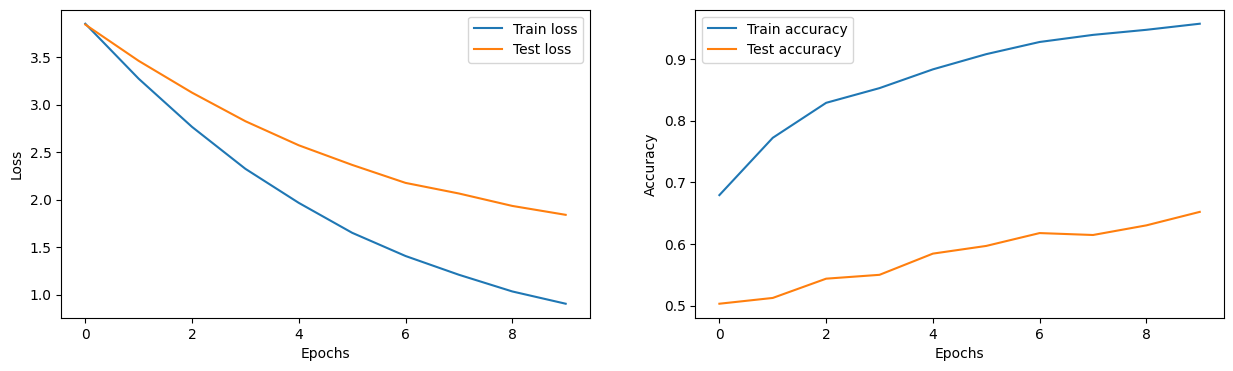

In [131]:
def visualize_history(history):
  assert list(sorted(history.keys())) == ['test_acc', 'test_loss', 'train_acc', 'train_loss'], "Keys aren't the same"
  epochs = np.arange(len(history["train_acc"]))
  fig = plt.figure(figsize=(15, 4))
  fig.add_subplot(1, 2, 1)
  plt.plot(epochs, history["train_loss"], label="Train loss")
  plt.plot(epochs, history["test_loss"], label="Test loss")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  fig.add_subplot(1, 2, 2)
  plt.plot(epochs, history["train_acc"], label="Train accuracy")
  plt.plot(epochs, history["test_acc"], label="Test accuracy")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")

visualize_history(model_1_results)

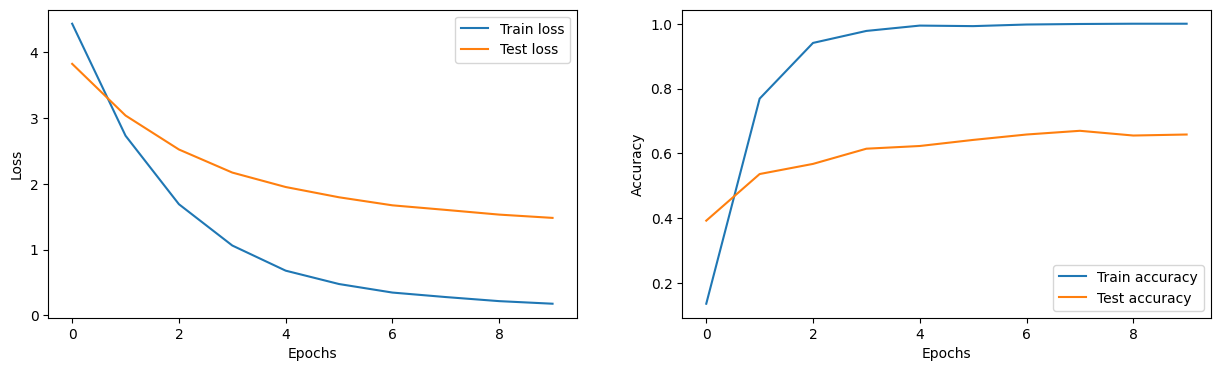

In [132]:
visualize_history(model_2_results)

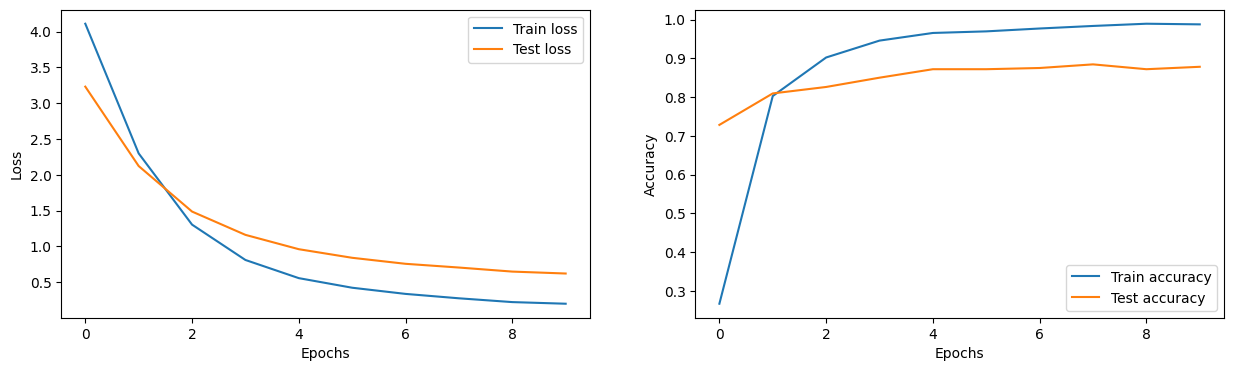

In [133]:
visualize_history(model_3_results)

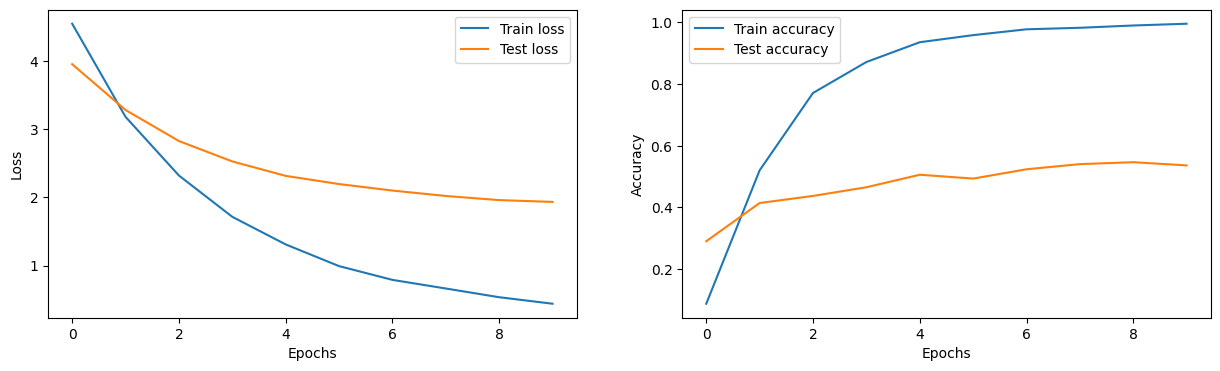

In [134]:
visualize_history(model_4_results)

In [135]:
def evaluate_on_test_set(model: torch.nn.Module,
                         test_set: torch.utils.data.DataLoader,
                         loss_fn: torch.nn.CrossEntropyLoss,
                         device: torch.device = device):
  model.eval()
  with torch.inference_mode():
    test_accuracy, test_loss = 0, 0
    for batch_id, (X, y) in enumerate(test_set):
      X, y = X.to(device), y.to(device)
      y_logits = model(X)
      test_loss += loss_fn(y_logits, y)
      test_accuracy += ((torch.softmax(y_logits, dim=-1).argmax(dim=-1) == y).sum().item()/len(y_logits))

    test_accuracy /= len(test_set)
    test_loss /= len(test_set)

  print(f"Test Accuracy: {test_accuracy*100:.2f}% | Test loss: {test_loss:.4f}")
  return test_accuracy, test_loss.item()

model_1_accuracy, model_1_loss = evaluate_on_test_set(model_1, efficientnet_valid_dataloader, loss_fn, device)

Test Accuracy: 65.21% | Test loss: 1.8389


In [136]:
model_2_accuracy, model_2_loss = evaluate_on_test_set(model_2, resnet_50_valid_dataloader, loss_fn, device)

Test Accuracy: 65.83% | Test loss: 1.4816


In [137]:
model_3_accuracy, model_3_loss = evaluate_on_test_set(model_3, efficientnetV2S_valid_dataloader, loss_fn, device)

Test Accuracy: 87.81% | Test loss: 0.6221


In [138]:
model_4_accuracy, model_4_loss = evaluate_on_test_set(model_4, mobilenet_valid_dataloader, loss_fn, device)

Test Accuracy: 53.65% | Test loss: 1.9332


## Saving models

In [141]:
from pathlib import Path
import torch
import pathlib

def save_model(target_directory: pathlib.Path,
               model: torch.nn.Module,
               model_name: str):
  assert model_name[-4:] == ".pth" or model_name[-3:] == ".pt", "Remember about .pth or .pt at the end of model_name!"
  if not target_directory.is_dir():
    target_directory.mkdir(parents=True,
                           exist_ok=True)
  # Save model weights to target directory
  print(f"Saving model to: {target_directory}")
  torch.save(model.state_dict(), Path(target_directory) / model_name)

In [146]:
from pathlib import Path

models_path = Path("drive/MyDrive/dog_breeds_data") / "models"
save_model(models_path, model_1, "efficientnet_model_1500.pth")
save_model(models_path, model_2, "resnet_model_1500.pth")
save_model(models_path, model_3, "efficientNetV2S_1500.pth")
save_model(models_path, model_4, "mobilenet_1500.pth")

Saving model to: drive/MyDrive/dog_breeds_data/models
Saving model to: drive/MyDrive/dog_breeds_data/models
Saving model to: drive/MyDrive/dog_breeds_data/models
Saving model to: drive/MyDrive/dog_breeds_data/models


# Conclusion

After a series of modelling experiments we can see that **EfficientNetV2S** performs the best. So we are going to use it on our entire dataset.

## Using entire dataset

In [149]:
X_train_full, X_valid_full, y_train_full, y_valid_full = train_test_split(train_paths,
                                                                          labels,
                                                                          test_size=0.2,
                                                                          random_state=42)
# Check the shapes
len(X_train_full), len(X_valid_full), len(y_train_full), len(y_valid_full)

(8177, 2045, 8177, 2045)

In [150]:
# Create custom training and validation datasets
train_dataloader, valid_dataloader = create_datasets(X_train_full, y_train_full,
                                                     X_valid_full, y_valid_full,
                                                     efficientnetV2S_data_transform,
                                                     efficientnetV2S_data_transform)
train_dataloader, valid_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a67d31c6fb0>,
 <torch.utils.data.dataloader.DataLoader at 0x7a67d31c43d0>)

In [152]:
final_model = efficientnet_v2_s(EfficientNet_V2_S_Weights.DEFAULT)
for layer in final_model.parameters():
  layer.requires_grad = False

# Freeze all the layers except last one
final_model.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True),
                                       nn.Linear(in_features=1280, out_features=NUM_CLASSES, bias=True))
# Check the summary of final model
summary(final_model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size",
                   "output_size",
                   "num_params",
                   "trainable",])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 120]                 --                        Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 24, 112, 112]        --                        False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 24, 112, 112]        (648)                     False
│    │    └─BatchNorm2d: 3-2                            [32, 24, 112, 112]        [32, 24, 112, 112]        (48)                      False
│    │    └─SiLU: 3-3                                   [32, 24, 112, 112]        [32, 24, 112, 112]        --                        --
│    └─Sequential

In [157]:
final_model_optimizer = torch.optim.Adam(params=final_model.parameters())
N_EPOCHS = 20

# Initialize the EarlyStopping callback (to reset all parameters like patience and best_score)
early_stopping = EarlyStopping(patience=5, store_best_weights=True)

model_3_results = train(final_model,
                        train_dataloader,
                        valid_dataloader,
                        final_model_optimizer,
                        loss_fn,
                        N_EPOCHS,
                        device,
                        "entire_dataset",
                        "efficientnetV2S_final_model",
                        f"{N_EPOCHS}_epochs")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8104 | train_acc: 0.7074 | test_loss: 0.6153 | test_acc: 0.8841
Early stopping callback status: 0/5 | Best score: None | Current score: 0.8841258081896551
Epoch: 2 | train_loss: 0.5132 | train_acc: 0.8827 | test_loss: 0.4029 | test_acc: 0.8993
Early stopping callback status: 0/5 | Best score: 0.8841258081896551 | Current score: 0.8992625269396551
Epoch: 3 | train_loss: 0.3650 | train_acc: 0.9088 | test_loss: 0.3451 | test_acc: 0.9007
Early stopping callback status: 0/5 | Best score: 0.8992625269396551 | Current score: 0.9007273706896551
Epoch: 4 | train_loss: 0.3067 | train_acc: 0.9163 | test_loss: 0.3236 | test_acc: 0.9022
Early stopping callback status: 0/5 | Best score: 0.9007273706896551 | Current score: 0.9021922144396551
Epoch: 5 | train_loss: 0.2670 | train_acc: 0.9285 | test_loss: 0.3165 | test_acc: 0.9056
Early stopping callback status: 0/5 | Best score: 0.9021922144396551 | Current score: 0.9056101831896551
Epoch: 6 | train_loss: 0.2321 | train_acc: 0

In [158]:
!rm -r /content/runs/entire_dataset/efficientnetV2S_final_model/30_epochs

In [159]:
save_model(models_path, final_model, "final_model_entire_dataset.pth")

Saving model to: drive/MyDrive/dog_breeds_data/models


## Confusion matrix and heatmap

In [198]:
final_model.eval()
true_labels = []
predictions = []
with torch.inference_mode():
  for batch_id, (X, y) in enumerate(valid_dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = torch.softmax(final_model(X), dim=-1).argmax(dim=-1)
    for i in range(len(y)):
      true_labels.append(y[i].item())
      predictions.append(y_pred[i].item())

true_labels[:10], predictions[:10]

([111, 56, 97, 40, 52, 47, 103, 115, 19, 29],
 [111, 56, 97, 40, 52, 47, 103, 115, 19, 29])

In [200]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

cm = confusion_matrix(true_labels, predictions)
cm_dataframe = pd.DataFrame(cm, columns=CLASS_NAMES, index=CLASS_NAMES)
cm_dataframe

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
affenpinscher,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
afghan_hound,0,22,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
african_hunting_dog,0,0,26,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
airedale,0,0,0,27,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
american_staffordshire_terrier,0,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
welsh_springer_spaniel,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,13,0,0,0,0
west_highland_white_terrier,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,13,0,0,0
whippet,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,14,0,0
wire-haired_fox_terrier,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,12,0


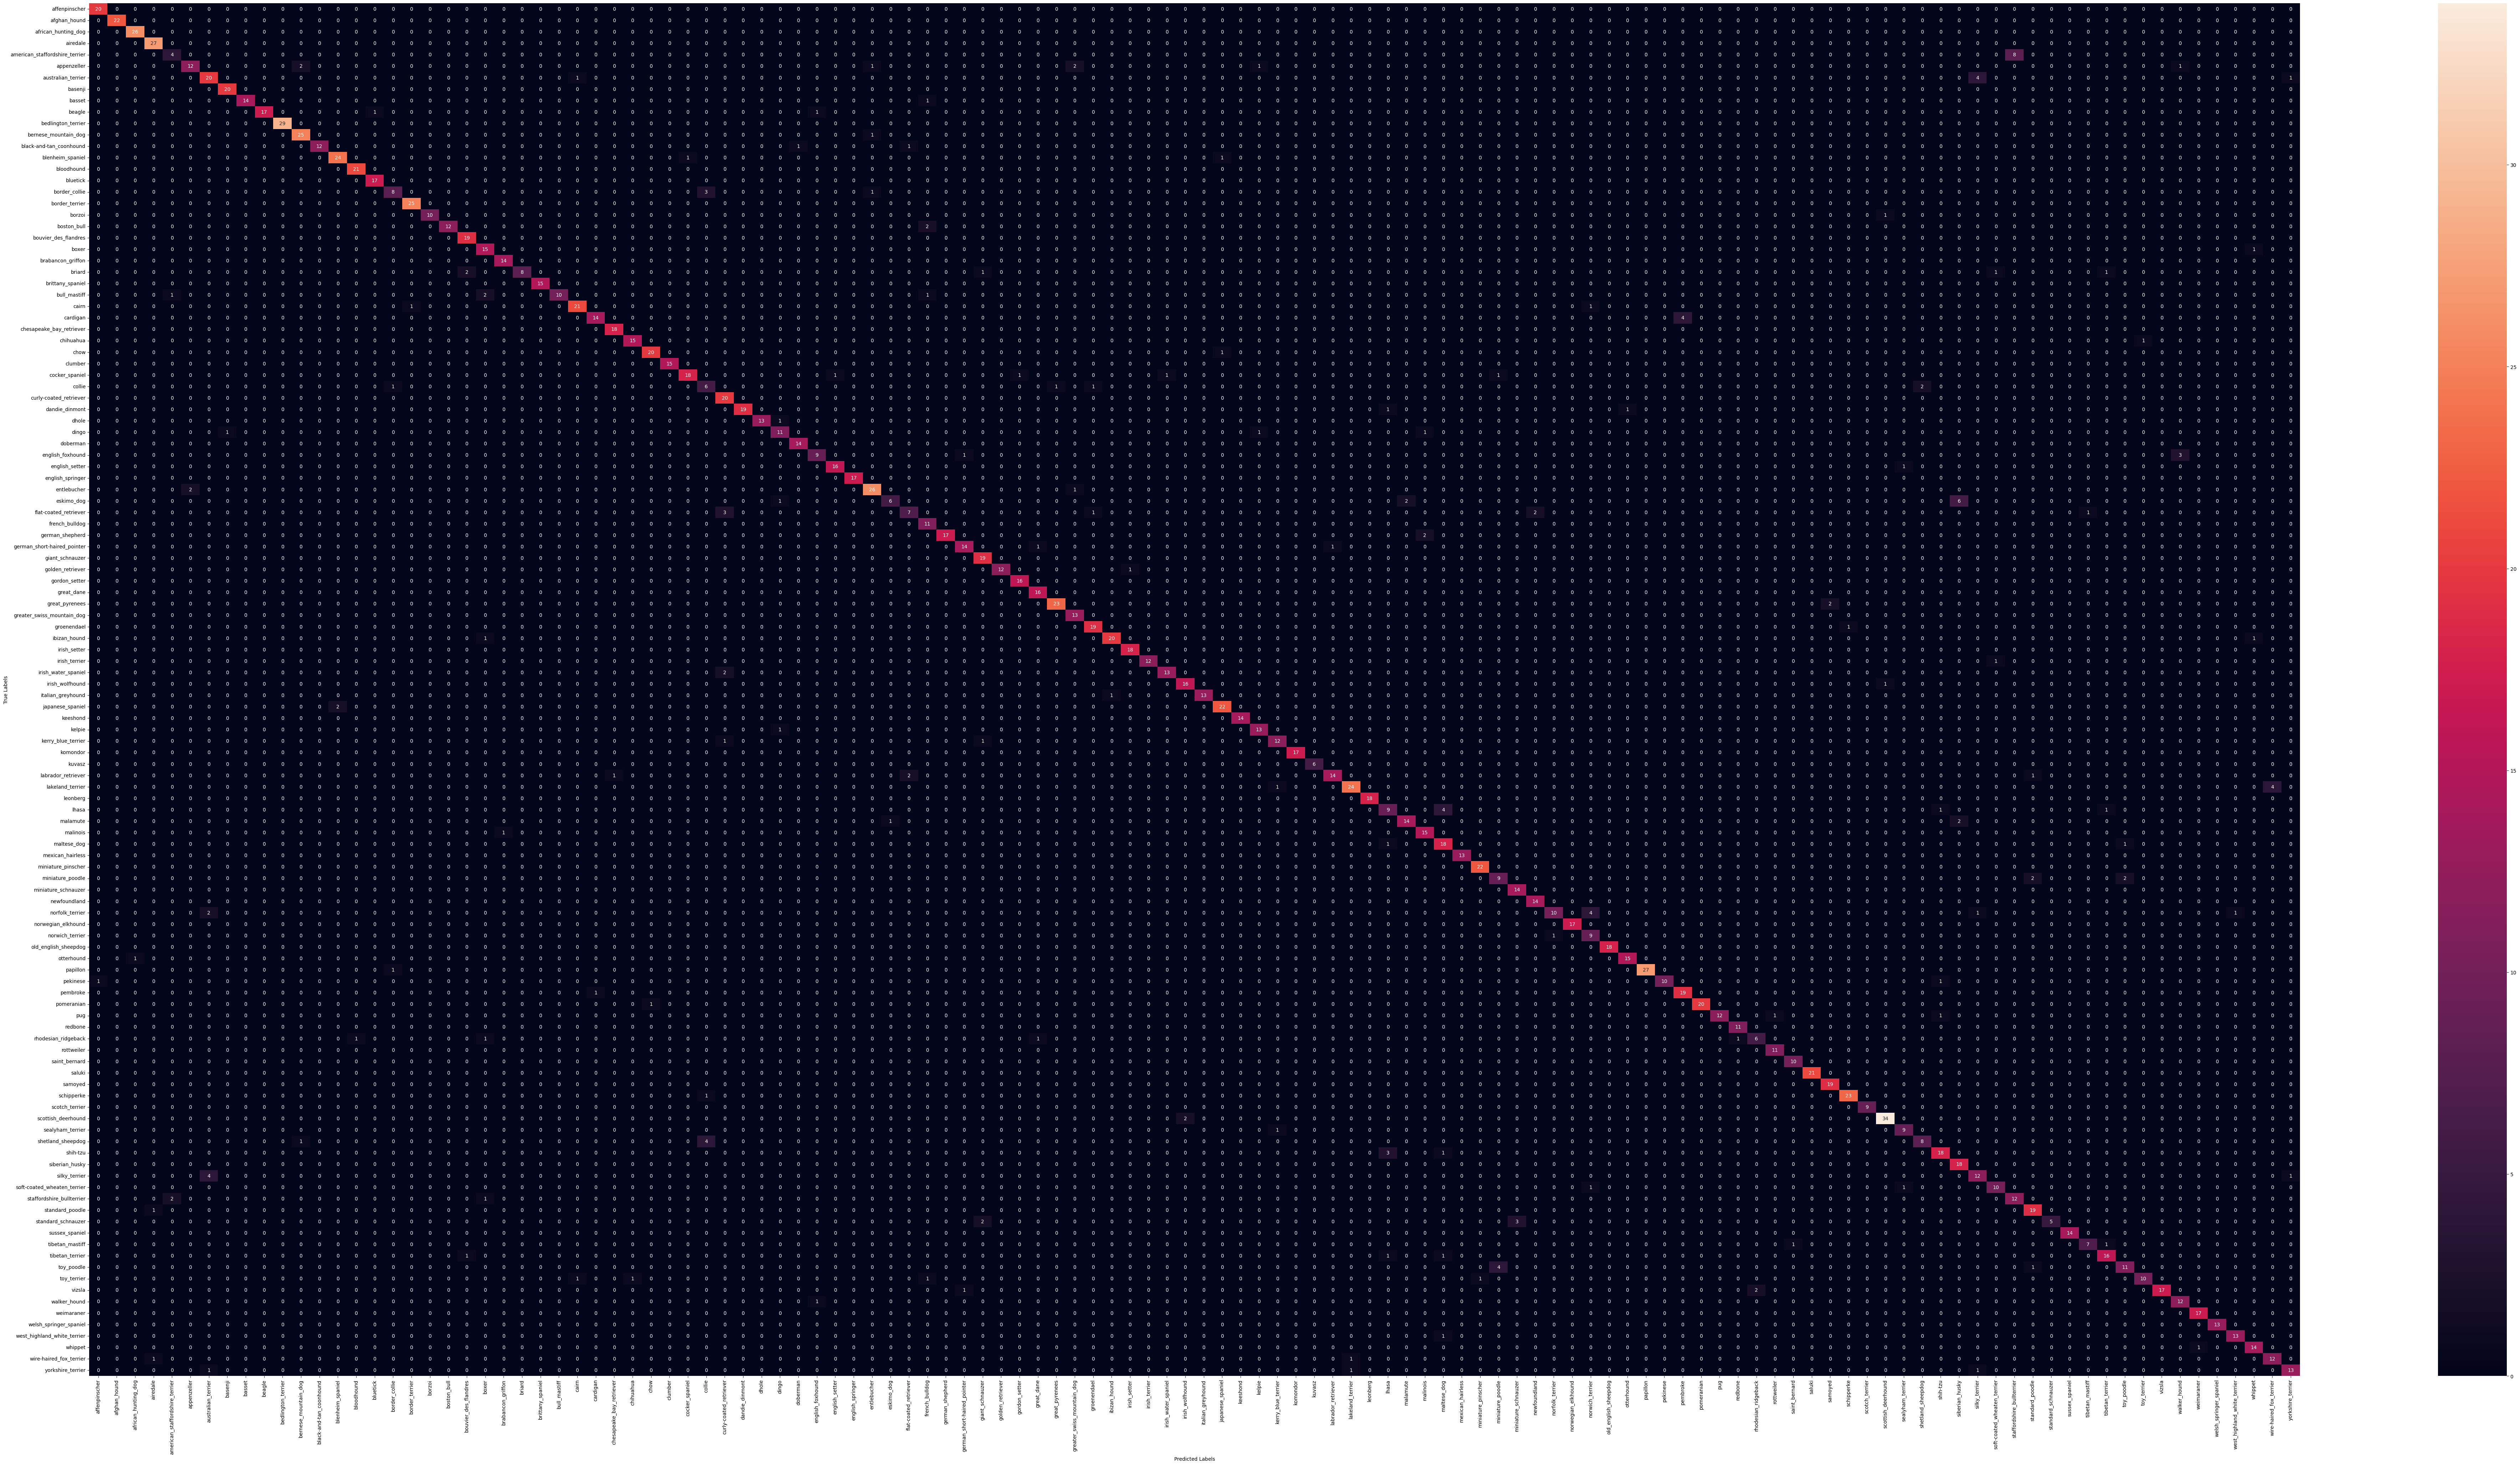

In [201]:
fig = plt.figure(figsize=(100, 50))
sns.heatmap(cm_dataframe,
            annot=True,
            fmt=".0f")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Preparing CSV file for kaggle submission

In [160]:
class TestDataset(torch.utils.data.Dataset):
  def __init__(self, test_filepaths, transforms=None):
    self.test_filepaths = test_filepaths
    self.transforms = transforms

  def __len__(self):
    return len(self.test_filepaths)

  def __getitem__(self, idx):
    image = Image.open(self.test_filepaths[idx])
    if self.transforms:
      image = self.transforms(image)
    return image

In [192]:
import os

def prepare_for_kaggle_submission(model,
                                  test_images_directory,
                                  transforms,
                                  CLASS_NAMES,
                                  device):
  image_ids = os.listdir(test_images_directory)
  # Get all test images filepaths
  test_images_paths = [test_images_directory + "/" + id
                       for id in image_ids]
  # Create test dataset
  test_dataset = TestDataset(test_images_paths,
                             transforms)
  # Batch our dataset
  test_dataloader = DataLoader(test_dataset,
                               shuffle=False,
                               batch_size=1,
                               num_workers=os.cpu_count(),
                               pin_memory=True)
  model.eval()
  submission = {"id": CLASS_NAMES}
  with torch.inference_mode():
    for batch_id, image in enumerate(test_dataloader):
      image = image.to(device)
      y_probabilities = torch.softmax(model(image), dim=-1)[0]
      image_id = image_ids[batch_id][:-4]
      submission[image_id] = np.array(y_probabilities.cpu())

  submission = pd.DataFrame(submission).T
  submission.columns = submission.iloc[0]
  submission = submission[1:]
  return submission#.to_csv(submission_csv_directory)

submission_df = prepare_for_kaggle_submission(final_model,
                                              "drive/MyDrive/dog_breeds_data/test",
                                              efficientnetV2S_data_transform,
                                              CLASS_NAMES,
                                              device)
submission_df.to_csv("drive/MyDrive/dog_breeds_data/submission.csv")